<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/change-how-image-files-are-retrieved/SRCNN_Comentada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports e definição de Constantes

In [1]:
try:
    from google.colab import files
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATASET_ROOT="/content/gdrive/MyDrive/TCC/datasets"
    !pip install patchify
    # wandb to log system metrics: (check CPU and GPU usage while session is runnig)
    !pip install wandb
    import wandb
    wandb.init()
    
    import save_model_helper

except ModuleNotFoundError:
    DATASET_ROOT="./datasets/"
    # coloquei as dependencias em um arquivo separado
    !pip install -r requirements.txt

import torch
torch.cuda.empty_cache()
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize
import pandas as pd
import time
import re
from pathlib import Path
import image_patches
import image_helper
import load_model_helper


DATASET_NAME = "Flickr2K"
# DATASET_NAME = "Set14"

# Mudar aqui se for para treinar salvando os dataframes e epochs no drive
# Se True, não pega nem salva nada no drive
EXPERIMENTAL_MODE = True


# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# garantir que é cuda
# assert device == "cuda"

# https://stackoverflow.com/questions/65734044/kernel-appears-to-have-died-jupyter-notebook-python-matplotlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# https://stackoverflow.com/a/74952995
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"


# Criando os patches

(patches já foram criados, não precisa rodar)

In [11]:
%time
# otimizacao: criar patches de treino, validacao e teste de uma vez: (32, 8, 2)
# image_patches.create_valid_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_train", 145)
# image_patches.create_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_validation", 20)

CPU times: total: 0 ns
Wall time: 0 ns


# ***SRCNN***

In [12]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=3, use_padding=True, initialization='normal'):
        super(SRCNN, self).__init__()
        self.initialization = initialization
        self.using_padding = use_padding
        padding = [0, 0, 0]
        if use_padding:
            padding = [9 // 2, 5 // 2, 5 // 2]
        # self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=padding[0])
        # self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=padding[1])
        # self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=padding[2])

        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=9, padding=(2, 2)
        )
        self.conv2 = nn.Conv2d(
            64, 32, kernel_size=1, padding=(2, 2)
        )
        self.conv3 = nn.Conv2d(
            32, 3, kernel_size=5, padding=(2, 2)
        )

        self.relu = nn.ReLU(inplace=True)
        
        # self.apply(self._init_weights)
        # self._init_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
    def _init_weights(self):
      # The filter weights of each layer are initialized by drawing randomly 
      # from a Gaussian distribution with zero mean and standard deviation 0.001 (and 0 for biases)
      for module in self.modules():
        if isinstance(module, nn.Conv2d):
          if self.initialization == "normal":
            module.weight.data.normal_(mean=0.0, std=0.001)
          elif self.initialization == "xavier":
            nn.init.xavier_normal_(module.weight.data)
          else:
            nn.init.eye_(module.weight.data)

          if module.bias is not None:
              module.bias.data.zero_()


In [13]:
# model_test = SRCNN(num_channels=3)

# input_1 = torch.randn([3, 33, 33])
# print(input_1.shape)

# output_1 = model_test(input_1)
# print(output_1.shape)

# Loops de **Treino** e **Validação**

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    print(f"Training on {size} samples...")
    print("Batch size:", dataloader.batch_size)
    print("Number of batches:", num_batches)

    train_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # X = X.to(device)
        # print("X", X.shape, X.get_device())
        # y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        # print(pred.shape, pred.get_device())
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= num_batches

    # return avg loss
    print(f"Training Error: \n Avg loss: {train_loss:>8f} \n")
    return train_loss

# will also be used for testing (maybe)
def validation_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            # X = X.to(device)
            # y = y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    validation_loss /= num_batches

    print(f"Validation Error: \n Avg loss: {validation_loss:>8f} \n")
    return validation_loss


# CustomImageDataset

In [15]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, patches_per_image = None | int, transform = None, target_transform = None, use_patches = True, device="cuda" if torch.cuda.is_available() else "cpu" ):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.patches_per_image = patches_per_image
        self.device = device
        
        self.file_list_tensor = self.create_tensors_from_images()
        self.file_list_tensor.to(device)

    def create_tensors_from_images(self):
      number_of_images = self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

      # creating the empty tensor
      image_tensors = torch.empty((number_of_images, 3, 33, 33))

      current_tensor_index = 0

      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      for patch_path in tqdm(list(os.listdir(all_patches_dir))):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue
          
          image_as_tensor = read_image(f"{self.img_dir}/{image_path}")

          # updating the created tensor
          image_tensors[current_tensor_index] = image_as_tensor.float() / 255

          current_tensor_index += 1
                    
      return image_tensors


    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
    
        image = self.file_list_tensor[idx]
        # image_x = image.detach().clone()
        # image_y = image.detach().clone()

        image_x = image.to(self.device)
        image_y = image.to(self.device)
        
        if self.transform:
            # image_x = self.transform(image_x)
            image_x = self.transform(image)
            # image_x = self.transform(image).to(device)
        if self.target_transform:
            #image_y = self.target_transform(image_y)
            image_y = self.target_transform(image)
            # image_y = self.target_transform(image).to(device)
            
          
        return image_x.to(self.device), image_y.to(self.device)

    def _get_number_of_images_in_folder(self, dir: str):
      """
      Gets the total number of all the patches
      """
      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      number_of_images = 0
      for patch_path in list(os.listdir(all_patches_dir)):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue

          number_of_images += 1

      return number_of_images

    def _check_if_image_is_not_corrupted(self, image_path: str) -> bool:
      """
      Returns True if the file is corrupted else returns False
      """
      file_size = Path(f"{self.img_dir}/{image_path}").stat().st_size

      if file_size == 0:
        print(f"Error loading image file: {self.img_dir}/{image_path}. Reason: file has size 0")
        return True
      
      return False

# Criando os ***Dataset*'s**

In [16]:
%%time
transform_x = transforms.Compose([
    # downscale by factor of 3 (from 33x33 to 11x11 back to 33x33)
    # resize image to 11x11 and downsample by BICUBIC interpolation
    transforms.Resize((11, 11), interpolation=Image.BICUBIC),
    # resize image to 33x33
    transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    # transforms.CenterCrop((33, 33))
])

transform_y = transforms.Compose([
    ##transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    #transforms.CenterCrop((21, 21))
    # transforms.CenterCrop((17, 17))
    # transforms.CenterCrop((25, 25))
    transforms.CenterCrop((33, 33))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_train", transform=transform_x, target_transform=transform_y)
validation_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_validation", transform=transform_x, target_transform=transform_y)

# # Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

100%|██████████| 2650/2650 [04:24<00:00, 10.03it/s]


Training set has 162186 instances
Validation set has 53000 instances
CPU times: total: 48.8 s
Wall time: 18min 45s


In [17]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(0.6*(2**13))
# batch_size = 2**13

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: total: 11.9 s
Wall time: 45.2 s


In [18]:
# save dataloader (https://discuss.pytorch.org/t/how-to-save-dataloader/62813/4)
# torch.save(train_dataloader, 'train_dataloader.pth')
# torch.save(train_dataloader, 'validation_dataloader.pth')

# Instanciando o modelo

In [19]:
# Instancianting the model
# Atencao: cuidado ao rodar o treino várias vezes sem resetar o modelo!
# model = SRCNN(initialization="normal")
# model.to(device)

In [20]:
model = SRCNN(num_channels=3)
model.to(device)

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

In [21]:
# img = image_patches.get_image_patch(f"{DATASET_ROOT}/{DATASET_NAME}_train").float()/255
# print(type(img), img.shape, img.dtype, img.min(), img.max())
# with torch.no_grad():
#   img_out = model(img.unsqueeze(0).to(device))
# print(type(img_out), img_out.shape, img_out.dtype, img_out.min(), img_out.max())
# # plt.figure()
# # plt.subplot(1, 2, 1)
# # plt.imshow(ImageHelperInstance.tensor_as_image(img.cpu()))
# # plt.subplot(1, 2, 2)
# # plt.imshow(ImageHelperInstance.tensor_as_image(img_out.squeeze().cpu()))
# # plt.show()

In [22]:
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(image_helper.tensor_as_image(img.cpu()))
# plt.subplot(1, 2, 2)
# plt.imshow(image_helper.tensor_as_image(img_out.squeeze().cpu()))
# plt.show()

# Criando o *Optmizer* e a *loss function* (MSE)

In [23]:
# otimizacao: Mudar o otimizador para Adam ou RMSProp
#           : Usar momentum = 0.9
#           : Usar learning maior: 1e-4?
#           : Usar learning rate decay

# hyperparameters
#https://stackoverflow.com/questions/48324152/pytorch-how-to-change-the-learning-rate-of-an-optimizer-at-any-given-moment-no
lr = 1e-3
model = SRCNN(num_channels=3, use_padding=False)
model.to(device)
# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.1,
#     patience=2,
#     threshold=1e-3,
#     verbose=True
#     )
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.1,
    total_iters=20)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()
loss_fn.to(device)

MSELoss()

# **Treinamento** 

## Execução das *epochs*
- Execução dos loops de treinamento e validação, e também salvamentos dos dados

In [24]:
# starting_epoch = load_model_helper.get_epoch_number_from_path(model_load_path_name)
# if starting_epoch is not None:
#   starting_epoch = starting_epoch + 1 # add 1 because we are starting after the epoch we left of
# print('starting_epoch =', starting_epoch)
starting_epoch = 0


In [103]:
lr = 0.00001
optimizer.param_groups[0]['lr'] = lr
# scheduler = torch.optim.lr_scheduler.LinearLR(
#     optimizer,
#     start_factor=1.0,
#     end_factor=0.1,
#     total_iters=5)

In [111]:
train_loss_array2 = []
for x in train_loss_array:
    train_loss_array2.append(x)
    
validation_loss_array2 = []
for x in validation_loss_array:
    validation_loss_array2.append(x)
    
print(len(train_loss_array2))
print(len(validation_loss_array2))

260
260


In [112]:
train_loss_array3 = train_loss_array2
validation_loss_array3 = validation_loss_array2

In [113]:
epoch_array_copy = epoch_array
time_array_copy = time_array
lr_array_copy = lr_array

In [114]:
# epoch_array = epoch_array[:-2]
# time_array = time_array[:-2]
# lr_array = lr_array[:-2]

print(len(time_array))

260


In [115]:
current_epoch = 260

In [116]:
%%time
train_loss = 0
validation_loss = 0
epochs = 150

######
# epoch_array = []
# time_array = []
# lr_array = []
######

# melhor usar lista e depois converter para array
# train_loss_array = list()
# validation_loss_array = list()
for index, t in enumerate(range(epochs)):
    print(f"\nepoch {current_epoch}\n-------------------------------")

    start_time = time.time()  # Start timing the epoch

    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    validation_loss = validation_loop(validation_dataloader, model, loss_fn)

    # changes the learning rate when the validation loss stops decreasing
    #scheduler.step(validation_loss)
    print(f"Learning rate (antes): {optimizer.param_groups[0]['lr']}")
#     scheduler.step()
    print(f"Learning rate (depois): {optimizer.param_groups[0]['lr']}")
    
    train_loss_array2.append(train_loss)
    validation_loss_array2.append(validation_loss)

    elapsed_time = time.time() - start_time  # Calculate elapsed time for the epoch
    
    ######
    epoch_array.append(current_epoch)
    time_array.append(elapsed_time)
    lr_array.append(optimizer.param_groups[0]['lr'])
    ######
    
    # updating learning rate
    # if current_epoch % 10 == 0 and current_epoch > 0:
    #     optimizer.param_groups[0]['lr'] /= 2

    current_epoch += 1
    
    if not EXPERIMENTAL_MODE:
      df_path = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/SRCNN_train_vs_validation_loss.csv'
      save_model_helper.save_df(df_path, train_loss, validation_loss, current_epoch, elapsed_time)
      save_model_helper.save_epoch(current_epoch, train_loss, validation_loss)
    
print("Done!")


epoch 260
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:48<00:00,  6.93s/it]


Training Error: 
 Avg loss: 0.007341 



100%|██████████| 11/11 [00:38<00:00,  3.48s/it]


Validation Error: 
 Avg loss: 0.003580 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 261
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [02:55<00:00,  5.33s/it]


Training Error: 
 Avg loss: 0.007341 



100%|██████████| 11/11 [00:37<00:00,  3.40s/it]


Validation Error: 
 Avg loss: 0.003580 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 262
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:00<00:00,  5.47s/it]


Training Error: 
 Avg loss: 0.007340 



100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


Validation Error: 
 Avg loss: 0.003578 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 263
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:01<00:00,  5.49s/it]


Training Error: 
 Avg loss: 0.007339 



100%|██████████| 11/11 [00:40<00:00,  3.64s/it]


Validation Error: 
 Avg loss: 0.003578 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 264
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:08<00:00,  5.72s/it]


Training Error: 
 Avg loss: 0.007338 



100%|██████████| 11/11 [00:37<00:00,  3.44s/it]


Validation Error: 
 Avg loss: 0.003577 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 265
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:08<00:00,  5.72s/it]


Training Error: 
 Avg loss: 0.007337 



100%|██████████| 11/11 [00:37<00:00,  3.41s/it]


Validation Error: 
 Avg loss: 0.003576 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 266
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:23<00:00,  6.17s/it]


Training Error: 
 Avg loss: 0.007336 



100%|██████████| 11/11 [00:38<00:00,  3.50s/it]


Validation Error: 
 Avg loss: 0.003575 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 267
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:07<00:00,  5.68s/it]


Training Error: 
 Avg loss: 0.007335 



100%|██████████| 11/11 [00:41<00:00,  3.75s/it]


Validation Error: 
 Avg loss: 0.003575 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 268
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:09<00:00,  5.74s/it]


Training Error: 
 Avg loss: 0.007334 



100%|██████████| 11/11 [00:39<00:00,  3.58s/it]


Validation Error: 
 Avg loss: 0.003574 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 269
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.84s/it]


Training Error: 
 Avg loss: 0.007333 



100%|██████████| 11/11 [00:39<00:00,  3.55s/it]


Validation Error: 
 Avg loss: 0.003573 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 270
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.81s/it]


Training Error: 
 Avg loss: 0.007333 



100%|██████████| 11/11 [00:42<00:00,  3.89s/it]


Validation Error: 
 Avg loss: 0.003572 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 271
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.77s/it]


Training Error: 
 Avg loss: 0.007332 



100%|██████████| 11/11 [00:38<00:00,  3.53s/it]


Validation Error: 
 Avg loss: 0.003571 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 272
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.88s/it]


Training Error: 
 Avg loss: 0.007331 



100%|██████████| 11/11 [00:45<00:00,  4.10s/it]


Validation Error: 
 Avg loss: 0.003571 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 273
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:15<00:00,  5.91s/it]


Training Error: 
 Avg loss: 0.007330 



100%|██████████| 11/11 [00:39<00:00,  3.62s/it]


Validation Error: 
 Avg loss: 0.003570 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 274
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.86s/it]


Training Error: 
 Avg loss: 0.007329 



100%|██████████| 11/11 [00:39<00:00,  3.58s/it]


Validation Error: 
 Avg loss: 0.003569 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 275
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.76s/it]


Training Error: 
 Avg loss: 0.007328 



100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


Validation Error: 
 Avg loss: 0.003569 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 276
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:09<00:00,  5.75s/it]


Training Error: 
 Avg loss: 0.007327 



100%|██████████| 11/11 [00:37<00:00,  3.39s/it]


Validation Error: 
 Avg loss: 0.003567 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 277
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.91s/it]


Training Error: 
 Avg loss: 0.007326 



100%|██████████| 11/11 [00:37<00:00,  3.39s/it]


Validation Error: 
 Avg loss: 0.003567 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 278
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.86s/it]


Training Error: 
 Avg loss: 0.007326 



100%|██████████| 11/11 [00:38<00:00,  3.54s/it]


Validation Error: 
 Avg loss: 0.003567 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 279
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:03<00:00,  5.55s/it]


Training Error: 
 Avg loss: 0.007325 



100%|██████████| 11/11 [00:39<00:00,  3.59s/it]


Validation Error: 
 Avg loss: 0.003565 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 280
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:17<00:00,  5.97s/it]


Training Error: 
 Avg loss: 0.007324 



100%|██████████| 11/11 [00:39<00:00,  3.59s/it]


Validation Error: 
 Avg loss: 0.003564 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 281
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:15<00:00,  5.93s/it]


Training Error: 
 Avg loss: 0.007323 



100%|██████████| 11/11 [00:40<00:00,  3.70s/it]


Validation Error: 
 Avg loss: 0.003563 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 282
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:16<00:00,  5.95s/it]


Training Error: 
 Avg loss: 0.007322 



100%|██████████| 11/11 [00:38<00:00,  3.48s/it]


Validation Error: 
 Avg loss: 0.003563 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 283
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.90s/it]


Training Error: 
 Avg loss: 0.007321 



100%|██████████| 11/11 [00:40<00:00,  3.64s/it]


Validation Error: 
 Avg loss: 0.003562 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 284
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.85s/it]


Training Error: 
 Avg loss: 0.007320 



100%|██████████| 11/11 [00:38<00:00,  3.47s/it]


Validation Error: 
 Avg loss: 0.003561 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 285
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.84s/it]


Training Error: 
 Avg loss: 0.007319 



100%|██████████| 11/11 [00:39<00:00,  3.56s/it]


Validation Error: 
 Avg loss: 0.003561 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 286
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:15<00:00,  5.92s/it]


Training Error: 
 Avg loss: 0.007318 



100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


Validation Error: 
 Avg loss: 0.003559 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 287
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:03<00:00,  5.55s/it]


Training Error: 
 Avg loss: 0.007317 



100%|██████████| 11/11 [00:38<00:00,  3.53s/it]


Validation Error: 
 Avg loss: 0.003559 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 288
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:09<00:00,  5.74s/it]


Training Error: 
 Avg loss: 0.007316 



100%|██████████| 11/11 [00:36<00:00,  3.29s/it]


Validation Error: 
 Avg loss: 0.003558 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 289
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.78s/it]


Training Error: 
 Avg loss: 0.007316 



100%|██████████| 11/11 [00:36<00:00,  3.34s/it]


Validation Error: 
 Avg loss: 0.003557 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 290
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.83s/it]


Training Error: 
 Avg loss: 0.007315 



100%|██████████| 11/11 [00:39<00:00,  3.60s/it]


Validation Error: 
 Avg loss: 0.003556 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 291
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:20<00:00,  6.08s/it]


Training Error: 
 Avg loss: 0.007314 



100%|██████████| 11/11 [00:40<00:00,  3.68s/it]


Validation Error: 
 Avg loss: 0.003556 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 292
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.87s/it]


Training Error: 
 Avg loss: 0.007313 



100%|██████████| 11/11 [00:39<00:00,  3.57s/it]


Validation Error: 
 Avg loss: 0.003555 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 293
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.86s/it]


Training Error: 
 Avg loss: 0.007312 



100%|██████████| 11/11 [00:36<00:00,  3.30s/it]


Validation Error: 
 Avg loss: 0.003554 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 294
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.88s/it]


Training Error: 
 Avg loss: 0.007311 



100%|██████████| 11/11 [00:41<00:00,  3.82s/it]


Validation Error: 
 Avg loss: 0.003553 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 295
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:04<00:00,  5.59s/it]


Training Error: 
 Avg loss: 0.007310 



100%|██████████| 11/11 [00:38<00:00,  3.48s/it]


Validation Error: 
 Avg loss: 0.003552 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 296
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.78s/it]


Training Error: 
 Avg loss: 0.007309 



100%|██████████| 11/11 [00:38<00:00,  3.49s/it]


Validation Error: 
 Avg loss: 0.003551 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 297
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.82s/it]


Training Error: 
 Avg loss: 0.007308 



100%|██████████| 11/11 [00:37<00:00,  3.38s/it]


Validation Error: 
 Avg loss: 0.003551 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 298
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:01<00:00,  5.49s/it]


Training Error: 
 Avg loss: 0.007307 



100%|██████████| 11/11 [00:39<00:00,  3.63s/it]


Validation Error: 
 Avg loss: 0.003550 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 299
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:06<00:00,  5.67s/it]


Training Error: 
 Avg loss: 0.007306 



100%|██████████| 11/11 [00:37<00:00,  3.39s/it]


Validation Error: 
 Avg loss: 0.003549 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 300
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:07<00:00,  5.67s/it]


Training Error: 
 Avg loss: 0.007306 



100%|██████████| 11/11 [00:36<00:00,  3.34s/it]


Validation Error: 
 Avg loss: 0.003548 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 301
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.77s/it]


Training Error: 
 Avg loss: 0.007305 



100%|██████████| 11/11 [00:36<00:00,  3.30s/it]


Validation Error: 
 Avg loss: 0.003547 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 302
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.85s/it]


Training Error: 
 Avg loss: 0.007304 



100%|██████████| 11/11 [00:36<00:00,  3.31s/it]


Validation Error: 
 Avg loss: 0.003546 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 303
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:09<00:00,  5.73s/it]


Training Error: 
 Avg loss: 0.007303 



100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


Validation Error: 
 Avg loss: 0.003546 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 304
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:18<00:00,  6.00s/it]


Training Error: 
 Avg loss: 0.007302 



100%|██████████| 11/11 [00:36<00:00,  3.34s/it]


Validation Error: 
 Avg loss: 0.003545 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 305
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.77s/it]


Training Error: 
 Avg loss: 0.007301 



100%|██████████| 11/11 [00:36<00:00,  3.33s/it]


Validation Error: 
 Avg loss: 0.003544 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 306
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:05<00:00,  5.61s/it]


Training Error: 
 Avg loss: 0.007300 



100%|██████████| 11/11 [00:39<00:00,  3.55s/it]


Validation Error: 
 Avg loss: 0.003543 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 307
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:04<00:00,  5.59s/it]


Training Error: 
 Avg loss: 0.007299 



100%|██████████| 11/11 [00:38<00:00,  3.48s/it]


Validation Error: 
 Avg loss: 0.003543 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 308
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:15<00:00,  5.91s/it]


Training Error: 
 Avg loss: 0.007298 



100%|██████████| 11/11 [00:36<00:00,  3.34s/it]


Validation Error: 
 Avg loss: 0.003541 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 309
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.82s/it]


Training Error: 
 Avg loss: 0.007297 



100%|██████████| 11/11 [00:38<00:00,  3.46s/it]


Validation Error: 
 Avg loss: 0.003541 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 310
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.81s/it]


Training Error: 
 Avg loss: 0.007296 



100%|██████████| 11/11 [00:36<00:00,  3.36s/it]


Validation Error: 
 Avg loss: 0.003540 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 311
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:03<00:00,  5.57s/it]


Training Error: 
 Avg loss: 0.007295 



100%|██████████| 11/11 [00:38<00:00,  3.53s/it]


Validation Error: 
 Avg loss: 0.003539 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 312
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:24<00:00,  6.19s/it]


Training Error: 
 Avg loss: 0.007295 



100%|██████████| 11/11 [00:38<00:00,  3.53s/it]


Validation Error: 
 Avg loss: 0.003539 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 313
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:19<00:00,  6.04s/it]


Training Error: 
 Avg loss: 0.007294 



100%|██████████| 11/11 [00:38<00:00,  3.46s/it]


Validation Error: 
 Avg loss: 0.003537 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 314
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:19<00:00,  6.05s/it]


Training Error: 
 Avg loss: 0.007293 



100%|██████████| 11/11 [00:42<00:00,  3.87s/it]


Validation Error: 
 Avg loss: 0.003537 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 315
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.77s/it]


Training Error: 
 Avg loss: 0.007292 



100%|██████████| 11/11 [00:41<00:00,  3.77s/it]


Validation Error: 
 Avg loss: 0.003537 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 316
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:35<00:00,  6.52s/it]


Training Error: 
 Avg loss: 0.007291 



100%|██████████| 11/11 [00:36<00:00,  3.31s/it]


Validation Error: 
 Avg loss: 0.003535 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 317
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.80s/it]


Training Error: 
 Avg loss: 0.007290 



100%|██████████| 11/11 [00:36<00:00,  3.30s/it]


Validation Error: 
 Avg loss: 0.003534 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 318
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.88s/it]


Training Error: 
 Avg loss: 0.007289 



100%|██████████| 11/11 [00:36<00:00,  3.29s/it]


Validation Error: 
 Avg loss: 0.003533 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 319
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:15<00:00,  5.93s/it]


Training Error: 
 Avg loss: 0.007288 



100%|██████████| 11/11 [00:39<00:00,  3.59s/it]


Validation Error: 
 Avg loss: 0.003532 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 320
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.87s/it]


Training Error: 
 Avg loss: 0.007287 



100%|██████████| 11/11 [00:36<00:00,  3.32s/it]


Validation Error: 
 Avg loss: 0.003532 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 321
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:09<00:00,  5.74s/it]


Training Error: 
 Avg loss: 0.007286 



100%|██████████| 11/11 [00:36<00:00,  3.27s/it]


Validation Error: 
 Avg loss: 0.003531 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 322
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.79s/it]


Training Error: 
 Avg loss: 0.007285 



100%|██████████| 11/11 [00:38<00:00,  3.48s/it]


Validation Error: 
 Avg loss: 0.003530 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 323
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:09<00:00,  5.73s/it]


Training Error: 
 Avg loss: 0.007284 



100%|██████████| 11/11 [00:37<00:00,  3.41s/it]


Validation Error: 
 Avg loss: 0.003530 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 324
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.79s/it]


Training Error: 
 Avg loss: 0.007284 



100%|██████████| 11/11 [00:35<00:00,  3.24s/it]


Validation Error: 
 Avg loss: 0.003529 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 325
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.81s/it]


Training Error: 
 Avg loss: 0.007283 



100%|██████████| 11/11 [00:37<00:00,  3.43s/it]


Validation Error: 
 Avg loss: 0.003528 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 326
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.81s/it]


Training Error: 
 Avg loss: 0.007282 



100%|██████████| 11/11 [00:39<00:00,  3.63s/it]


Validation Error: 
 Avg loss: 0.003527 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 327
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:18<00:00,  6.03s/it]


Training Error: 
 Avg loss: 0.007281 



100%|██████████| 11/11 [00:36<00:00,  3.36s/it]


Validation Error: 
 Avg loss: 0.003527 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 328
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:17<00:00,  5.97s/it]


Training Error: 
 Avg loss: 0.007280 



100%|██████████| 11/11 [00:46<00:00,  4.18s/it]


Validation Error: 
 Avg loss: 0.003525 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 329
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.79s/it]


Training Error: 
 Avg loss: 0.007279 



100%|██████████| 11/11 [00:37<00:00,  3.37s/it]


Validation Error: 
 Avg loss: 0.003525 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 330
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.82s/it]


Training Error: 
 Avg loss: 0.007278 



100%|██████████| 11/11 [00:39<00:00,  3.62s/it]


Validation Error: 
 Avg loss: 0.003524 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 331
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.83s/it]


Training Error: 
 Avg loss: 0.007277 



100%|██████████| 11/11 [00:39<00:00,  3.58s/it]


Validation Error: 
 Avg loss: 0.003523 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 332
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.88s/it]


Training Error: 
 Avg loss: 0.007276 



100%|██████████| 11/11 [00:39<00:00,  3.57s/it]


Validation Error: 
 Avg loss: 0.003523 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 333
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:17<00:00,  5.98s/it]


Training Error: 
 Avg loss: 0.007276 



100%|██████████| 11/11 [00:39<00:00,  3.57s/it]


Validation Error: 
 Avg loss: 0.003522 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 334
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:16<00:00,  5.94s/it]


Training Error: 
 Avg loss: 0.007275 



100%|██████████| 11/11 [00:36<00:00,  3.32s/it]


Validation Error: 
 Avg loss: 0.003521 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 335
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.90s/it]


Training Error: 
 Avg loss: 0.007274 



100%|██████████| 11/11 [00:37<00:00,  3.45s/it]


Validation Error: 
 Avg loss: 0.003520 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 336
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:03<00:00,  5.56s/it]


Training Error: 
 Avg loss: 0.007273 



100%|██████████| 11/11 [00:36<00:00,  3.36s/it]


Validation Error: 
 Avg loss: 0.003519 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 337
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.80s/it]


Training Error: 
 Avg loss: 0.007272 



100%|██████████| 11/11 [00:35<00:00,  3.27s/it]


Validation Error: 
 Avg loss: 0.003518 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 338
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.88s/it]


Training Error: 
 Avg loss: 0.007271 



100%|██████████| 11/11 [00:36<00:00,  3.29s/it]


Validation Error: 
 Avg loss: 0.003518 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 339
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:17<00:00,  5.98s/it]


Training Error: 
 Avg loss: 0.007270 



100%|██████████| 11/11 [00:39<00:00,  3.60s/it]


Validation Error: 
 Avg loss: 0.003517 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 340
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:15<00:00,  5.92s/it]


Training Error: 
 Avg loss: 0.007269 



100%|██████████| 11/11 [00:39<00:00,  3.60s/it]


Validation Error: 
 Avg loss: 0.003517 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 341
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:16<00:00,  5.97s/it]


Training Error: 
 Avg loss: 0.007268 



100%|██████████| 11/11 [00:39<00:00,  3.59s/it]


Validation Error: 
 Avg loss: 0.003516 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 342
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.78s/it]


Training Error: 
 Avg loss: 0.007268 



100%|██████████| 11/11 [00:39<00:00,  3.55s/it]


Validation Error: 
 Avg loss: 0.003515 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 343
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:08<00:00,  5.72s/it]


Training Error: 
 Avg loss: 0.007267 



100%|██████████| 11/11 [00:39<00:00,  3.56s/it]


Validation Error: 
 Avg loss: 0.003514 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 344
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:15<00:00,  5.93s/it]


Training Error: 
 Avg loss: 0.007266 



100%|██████████| 11/11 [00:41<00:00,  3.80s/it]


Validation Error: 
 Avg loss: 0.003513 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 345
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:18<00:00,  6.00s/it]


Training Error: 
 Avg loss: 0.007265 



100%|██████████| 11/11 [00:37<00:00,  3.40s/it]


Validation Error: 
 Avg loss: 0.003513 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 346
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:04<00:00,  5.60s/it]


Training Error: 
 Avg loss: 0.007264 



100%|██████████| 11/11 [00:37<00:00,  3.39s/it]


Validation Error: 
 Avg loss: 0.003512 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 347
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.82s/it]


Training Error: 
 Avg loss: 0.007263 



100%|██████████| 11/11 [00:39<00:00,  3.61s/it]


Validation Error: 
 Avg loss: 0.003511 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 348
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.89s/it]


Training Error: 
 Avg loss: 0.007262 



100%|██████████| 11/11 [00:37<00:00,  3.45s/it]


Validation Error: 
 Avg loss: 0.003511 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 349
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:03<00:00,  5.57s/it]


Training Error: 
 Avg loss: 0.007262 



100%|██████████| 11/11 [00:35<00:00,  3.25s/it]


Validation Error: 
 Avg loss: 0.003509 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 350
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:06<00:00,  5.66s/it]


Training Error: 
 Avg loss: 0.007261 



100%|██████████| 11/11 [00:35<00:00,  3.27s/it]


Validation Error: 
 Avg loss: 0.003509 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 351
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:02<00:00,  5.54s/it]


Training Error: 
 Avg loss: 0.007260 



100%|██████████| 11/11 [00:40<00:00,  3.68s/it]


Validation Error: 
 Avg loss: 0.003509 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 352
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:08<00:00,  5.71s/it]


Training Error: 
 Avg loss: 0.007259 



100%|██████████| 11/11 [00:38<00:00,  3.50s/it]


Validation Error: 
 Avg loss: 0.003508 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 353
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.76s/it]


Training Error: 
 Avg loss: 0.007258 



100%|██████████| 11/11 [00:38<00:00,  3.49s/it]


Validation Error: 
 Avg loss: 0.003507 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 354
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:09<00:00,  5.74s/it]


Training Error: 
 Avg loss: 0.007257 



100%|██████████| 11/11 [00:38<00:00,  3.49s/it]


Validation Error: 
 Avg loss: 0.003506 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 355
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:02<00:00,  5.53s/it]


Training Error: 
 Avg loss: 0.007257 



100%|██████████| 11/11 [00:38<00:00,  3.54s/it]


Validation Error: 
 Avg loss: 0.003505 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 356
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:02<00:00,  5.53s/it]


Training Error: 
 Avg loss: 0.007256 



100%|██████████| 11/11 [00:40<00:00,  3.71s/it]


Validation Error: 
 Avg loss: 0.003505 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 357
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:01<00:00,  5.50s/it]


Training Error: 
 Avg loss: 0.007255 



100%|██████████| 11/11 [00:35<00:00,  3.25s/it]


Validation Error: 
 Avg loss: 0.003504 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 358
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:02<00:00,  5.52s/it]


Training Error: 
 Avg loss: 0.007254 



100%|██████████| 11/11 [00:37<00:00,  3.37s/it]


Validation Error: 
 Avg loss: 0.003503 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 359
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:01<00:00,  5.49s/it]


Training Error: 
 Avg loss: 0.007253 



100%|██████████| 11/11 [00:39<00:00,  3.62s/it]


Validation Error: 
 Avg loss: 0.003502 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 360
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:02<00:00,  5.53s/it]


Training Error: 
 Avg loss: 0.007252 



100%|██████████| 11/11 [00:38<00:00,  3.48s/it]


Validation Error: 
 Avg loss: 0.003502 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 361
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:02<00:00,  5.52s/it]


Training Error: 
 Avg loss: 0.007252 



100%|██████████| 11/11 [00:39<00:00,  3.58s/it]


Validation Error: 
 Avg loss: 0.003501 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 362
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:01<00:00,  5.50s/it]


Training Error: 
 Avg loss: 0.007251 



100%|██████████| 11/11 [00:38<00:00,  3.47s/it]


Validation Error: 
 Avg loss: 0.003501 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 363
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:00<00:00,  5.47s/it]


Training Error: 
 Avg loss: 0.007250 



100%|██████████| 11/11 [00:40<00:00,  3.67s/it]


Validation Error: 
 Avg loss: 0.003500 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 364
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:02<00:00,  5.54s/it]


Training Error: 
 Avg loss: 0.007249 



100%|██████████| 11/11 [00:36<00:00,  3.35s/it]


Validation Error: 
 Avg loss: 0.003500 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 365
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.80s/it]


Training Error: 
 Avg loss: 0.007248 



100%|██████████| 11/11 [00:38<00:00,  3.47s/it]


Validation Error: 
 Avg loss: 0.003499 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 366
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:19<00:00,  6.04s/it]


Training Error: 
 Avg loss: 0.007248 



100%|██████████| 11/11 [00:37<00:00,  3.44s/it]


Validation Error: 
 Avg loss: 0.003498 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 367
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.90s/it]


Training Error: 
 Avg loss: 0.007247 



100%|██████████| 11/11 [00:38<00:00,  3.46s/it]


Validation Error: 
 Avg loss: 0.003498 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 368
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.84s/it]


Training Error: 
 Avg loss: 0.007246 



100%|██████████| 11/11 [00:52<00:00,  4.78s/it]


Validation Error: 
 Avg loss: 0.003497 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 369
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:23<00:00,  6.17s/it]


Training Error: 
 Avg loss: 0.007245 



100%|██████████| 11/11 [00:39<00:00,  3.62s/it]


Validation Error: 
 Avg loss: 0.003496 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 370
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:07<00:00,  5.67s/it]


Training Error: 
 Avg loss: 0.007244 



100%|██████████| 11/11 [00:39<00:00,  3.63s/it]


Validation Error: 
 Avg loss: 0.003495 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 371
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.87s/it]


Training Error: 
 Avg loss: 0.007244 



100%|██████████| 11/11 [00:39<00:00,  3.56s/it]


Validation Error: 
 Avg loss: 0.003494 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 372
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.90s/it]


Training Error: 
 Avg loss: 0.007243 



100%|██████████| 11/11 [00:40<00:00,  3.71s/it]


Validation Error: 
 Avg loss: 0.003494 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 373
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.86s/it]


Training Error: 
 Avg loss: 0.007242 



100%|██████████| 11/11 [00:37<00:00,  3.39s/it]


Validation Error: 
 Avg loss: 0.003493 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 374
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.77s/it]


Training Error: 
 Avg loss: 0.007241 



100%|██████████| 11/11 [00:37<00:00,  3.42s/it]


Validation Error: 
 Avg loss: 0.003492 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 375
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.83s/it]


Training Error: 
 Avg loss: 0.007240 



100%|██████████| 11/11 [00:38<00:00,  3.50s/it]


Validation Error: 
 Avg loss: 0.003491 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 376
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:08<00:00,  5.71s/it]


Training Error: 
 Avg loss: 0.007240 



100%|██████████| 11/11 [00:35<00:00,  3.23s/it]


Validation Error: 
 Avg loss: 0.003492 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 377
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.85s/it]


Training Error: 
 Avg loss: 0.007239 



100%|██████████| 11/11 [00:37<00:00,  3.37s/it]


Validation Error: 
 Avg loss: 0.003490 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 378
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:06<00:00,  5.64s/it]


Training Error: 
 Avg loss: 0.007237 



100%|██████████| 11/11 [00:35<00:00,  3.27s/it]


Validation Error: 
 Avg loss: 0.003489 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 379
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:07<00:00,  5.70s/it]


Training Error: 
 Avg loss: 0.007237 



100%|██████████| 11/11 [00:39<00:00,  3.56s/it]


Validation Error: 
 Avg loss: 0.003489 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 380
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:08<00:00,  5.72s/it]


Training Error: 
 Avg loss: 0.007236 



100%|██████████| 11/11 [00:36<00:00,  3.30s/it]


Validation Error: 
 Avg loss: 0.003488 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 381
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:04<00:00,  5.59s/it]


Training Error: 
 Avg loss: 0.007235 



100%|██████████| 11/11 [00:39<00:00,  3.63s/it]


Validation Error: 
 Avg loss: 0.003487 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 382
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [02:59<00:00,  5.44s/it]


Training Error: 
 Avg loss: 0.007234 



100%|██████████| 11/11 [00:40<00:00,  3.71s/it]


Validation Error: 
 Avg loss: 0.003486 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 383
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:07<00:00,  5.69s/it]


Training Error: 
 Avg loss: 0.007233 



100%|██████████| 11/11 [00:38<00:00,  3.53s/it]


Validation Error: 
 Avg loss: 0.003486 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 384
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.80s/it]


Training Error: 
 Avg loss: 0.007232 



100%|██████████| 11/11 [00:37<00:00,  3.43s/it]


Validation Error: 
 Avg loss: 0.003486 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 385
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.78s/it]


Training Error: 
 Avg loss: 0.007231 



100%|██████████| 11/11 [00:35<00:00,  3.19s/it]


Validation Error: 
 Avg loss: 0.003485 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 386
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.79s/it]


Training Error: 
 Avg loss: 0.007231 



100%|██████████| 11/11 [00:36<00:00,  3.31s/it]


Validation Error: 
 Avg loss: 0.003484 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 387
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.85s/it]


Training Error: 
 Avg loss: 0.007230 



100%|██████████| 11/11 [00:39<00:00,  3.60s/it]


Validation Error: 
 Avg loss: 0.003483 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 388
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.81s/it]


Training Error: 
 Avg loss: 0.007229 



100%|██████████| 11/11 [00:39<00:00,  3.56s/it]


Validation Error: 
 Avg loss: 0.003482 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 389
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.83s/it]


Training Error: 
 Avg loss: 0.007228 



100%|██████████| 11/11 [00:36<00:00,  3.33s/it]


Validation Error: 
 Avg loss: 0.003482 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 390
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:13<00:00,  5.86s/it]


Training Error: 
 Avg loss: 0.007228 



100%|██████████| 11/11 [00:37<00:00,  3.39s/it]


Validation Error: 
 Avg loss: 0.003482 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 391
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:37<00:00,  6.58s/it]


Training Error: 
 Avg loss: 0.007227 



100%|██████████| 11/11 [00:40<00:00,  3.66s/it]


Validation Error: 
 Avg loss: 0.003481 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 392
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.89s/it]


Training Error: 
 Avg loss: 0.007226 



100%|██████████| 11/11 [00:39<00:00,  3.60s/it]


Validation Error: 
 Avg loss: 0.003480 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 393
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:17<00:00,  5.99s/it]


Training Error: 
 Avg loss: 0.007225 



100%|██████████| 11/11 [00:39<00:00,  3.56s/it]


Validation Error: 
 Avg loss: 0.003479 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 394
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:31<00:00,  6.42s/it]


Training Error: 
 Avg loss: 0.007225 



100%|██████████| 11/11 [00:39<00:00,  3.55s/it]


Validation Error: 
 Avg loss: 0.003479 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 395
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:11<00:00,  5.80s/it]


Training Error: 
 Avg loss: 0.007224 



100%|██████████| 11/11 [00:36<00:00,  3.30s/it]


Validation Error: 
 Avg loss: 0.003478 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 396
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:02<00:00,  5.54s/it]


Training Error: 
 Avg loss: 0.007223 



100%|██████████| 11/11 [00:40<00:00,  3.67s/it]


Validation Error: 
 Avg loss: 0.003478 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 397
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [02:59<00:00,  5.44s/it]


Training Error: 
 Avg loss: 0.007222 



100%|██████████| 11/11 [00:38<00:00,  3.52s/it]


Validation Error: 
 Avg loss: 0.003477 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 398
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:03<00:00,  5.55s/it]


Training Error: 
 Avg loss: 0.007222 



100%|██████████| 11/11 [00:38<00:00,  3.50s/it]


Validation Error: 
 Avg loss: 0.003476 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 399
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:03<00:00,  5.57s/it]


Training Error: 
 Avg loss: 0.007221 



100%|██████████| 11/11 [00:36<00:00,  3.32s/it]


Validation Error: 
 Avg loss: 0.003476 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 400
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:02<00:00,  5.53s/it]


Training Error: 
 Avg loss: 0.007220 



100%|██████████| 11/11 [00:40<00:00,  3.67s/it]


Validation Error: 
 Avg loss: 0.003475 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 401
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:00<00:00,  5.46s/it]


Training Error: 
 Avg loss: 0.007219 



100%|██████████| 11/11 [00:37<00:00,  3.45s/it]


Validation Error: 
 Avg loss: 0.003474 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 402
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:10<00:00,  5.77s/it]


Training Error: 
 Avg loss: 0.007219 



100%|██████████| 11/11 [00:37<00:00,  3.42s/it]


Validation Error: 
 Avg loss: 0.003474 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 403
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.84s/it]


Training Error: 
 Avg loss: 0.007218 



100%|██████████| 11/11 [00:38<00:00,  3.52s/it]


Validation Error: 
 Avg loss: 0.003473 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 404
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:14<00:00,  5.90s/it]


Training Error: 
 Avg loss: 0.007217 



100%|██████████| 11/11 [00:40<00:00,  3.64s/it]


Validation Error: 
 Avg loss: 0.003473 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 405
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:01<00:00,  5.51s/it]


Training Error: 
 Avg loss: 0.007217 



100%|██████████| 11/11 [00:37<00:00,  3.38s/it]


Validation Error: 
 Avg loss: 0.003472 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 406
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:03<00:00,  5.55s/it]


Training Error: 
 Avg loss: 0.007216 



100%|██████████| 11/11 [00:40<00:00,  3.65s/it]


Validation Error: 
 Avg loss: 0.003473 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 407
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:01<00:00,  5.51s/it]


Training Error: 
 Avg loss: 0.007215 



100%|██████████| 11/11 [00:41<00:00,  3.73s/it]


Validation Error: 
 Avg loss: 0.003472 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 408
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:05<00:00,  5.63s/it]


Training Error: 
 Avg loss: 0.007215 



100%|██████████| 11/11 [00:38<00:00,  3.52s/it]


Validation Error: 
 Avg loss: 0.003471 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05

epoch 409
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:12<00:00,  5.82s/it]


Training Error: 
 Avg loss: 0.007214 



100%|██████████| 11/11 [00:39<00:00,  3.59s/it]

Validation Error: 
 Avg loss: 0.003469 

Learning rate (antes): 1e-05
Learning rate (depois): 1e-05
Done!
CPU times: total: 8h 36min 19s
Wall time: 11h 59min 24s


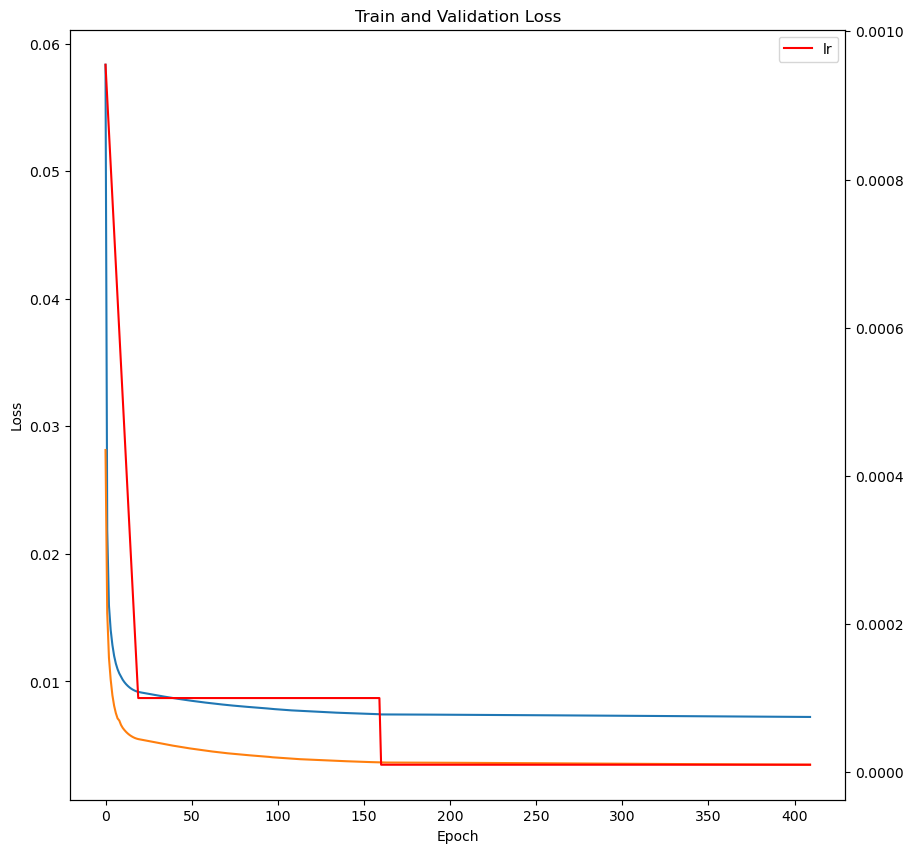

In [117]:
train_loss_array = np.array(train_loss_array2)
validation_loss_array = np.array(validation_loss_array2)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(range(len(train_loss_array)), train_loss_array, label='train_loss')
ax.plot(range(len(validation_loss_array)), validation_loss_array, label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

ax2 = ax.twinx()
ax2.plot(range(len(lr_array)), lr_array, label='lr', color='red')

plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [118]:
df = pd.DataFrame({'Train Loss': train_loss_array2, 'Validation Loss': validation_loss_array2, 'epoch': epoch_array, 'learning rate': lr_array, 'epoch_duration [s]': time_array})
df.head()

,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
0,0.058341,0.028139,0,0.000955,450.271599
1,0.021852,0.015344,1,0.000910,372.676117
2,0.015949,0.011855,2,0.000865,328.428911
3,0.014041,0.010150,3,0.000820,305.808165
4,0.012861,0.008920,4,0.000775,318.241299


In [119]:
df

,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
0,0.058341,0.028139,0,0.000955,450.271599
1,0.021852,0.015344,1,0.000910,372.676117
2,0.015949,0.011855,2,0.000865,328.428911
3,0.014041,0.010150,3,0.000820,305.808165
4,0.012861,0.008920,4,0.000775,318.241299
...,...,...,...,...,...
405,0.007217,0.003472,405,0.000010,276.721320
406,0.007216,0.003473,406,0.000010,281.237808
407,0.007215,0.003472,407,0.000010,278.266929
408,0.007215,0.003471,408,0.000010,284.862211


# Tesntando o modelo em uma imagem

C:\Users\Pedro\AppData\Local\Temp\ipykernel_18392\3721638021.py:5: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((new_image.size[1] // 2, new_image.size[0] // 2), interpolation=Image.LINEAR),
C:\Users\Pedro\AppData\Local\Temp\ipykernel_18392\3721638021.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((new_image.size[1], new_image.size[0]), interpolation=Image.LINEAR)
C:\Users\Pedro\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=No

(250, 361)
torch.Size([3, 361, 250])
255


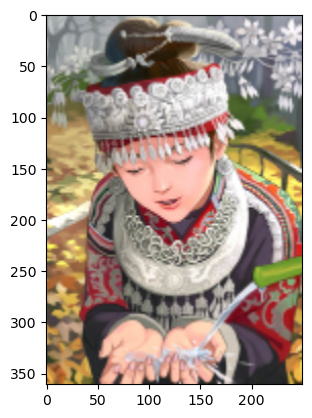

In [120]:
new_image = Image.open(f"{DATASET_ROOT}Set14/comic.png")
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((new_image.size[1] // 2, new_image.size[0] // 2), interpolation=Image.LINEAR),
    # resize image to 256x256
    transforms.Resize((new_image.size[1], new_image.size[0]), interpolation=Image.LINEAR)
])

print(new_image.size)


new_image_lr = transform(new_image)
print(new_image_lr.shape)
print(np.array(new_image).max())
image_helper.show_tensor_as_image(new_image_lr) # mudar pro arquivo novo


In [31]:
# new_image.size

In [32]:
# new_image = Image.open(f"{DATASET_ROOT}/Flickr2K/000400.png")
# plt.figure()
# plt.imshow(new_image)
# plt.show()

In [36]:
# import matplotlib.pyplot as plt

plt.figure()
new_image_sr = model(new_image_lr.to(device))
new_image_sr_np = new_image_sr.cpu().detach().numpy()
# new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [34]:
# model(torch.randn([3, 33, 33]).to(device))

In [35]:
# abc = torch.mul(new_image_sr, 2)
# abc_np = abc.cpu().detach().numpy()

# abc = new_image_sr
# a = model(new_img)

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure()
# abc = torch.mul(new_image_sr, 0.4)
# abc_np = abc.cpu().detach().numpy()
# plt.imshow(abc_np.transpose((1, 2, 0)))
# plt.show()

In [121]:
torch.save(model.state_dict(), './srcnn_03_07-v4.pth')

In [57]:
model_2 = SRCNN(num_channels=3).to(device)
try:
    model_2.load_state_dict(torch.load('./srcnn_03_07.pth'))
except:
    model_2.load_state_dict(torch.load('./srcnn_03_07.pth', map_location=torch.device('cpu')))

In [122]:
df.to_csv('srcnn_03_07-v4.csv')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


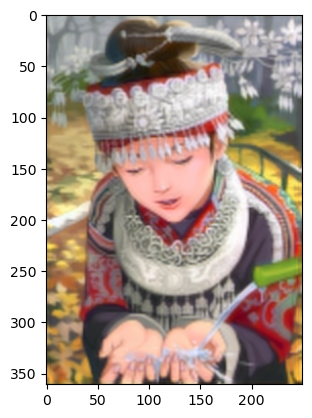

In [53]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr = model_2(new_image_lr.to(device))
new_image_sr_np = new_image_sr.cpu().detach().numpy()
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


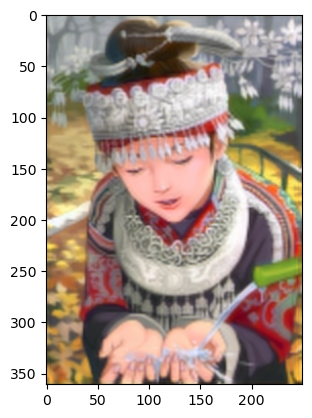

In [54]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr = model(new_image_lr.to(device))
new_image_sr_np = new_image_sr.cpu().detach().numpy()
# new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()